In [2]:
import pandas as pd

#sun_df = pd.read_csv('copy_number/hg38_features.txt', sep='\t')
#sun_df.columns = ['loc', 'NAB', 'NC', 'ND', 'NN']
#sun_df = (sun_df.set_index('loc') * 2).reset_index()
#sun_df.head()

In [3]:


# try using the SUN VCF
import vcf
vcf_path = "/hive/users/ifiddes/amplicon_analysis_with_new_suns/all_samples_reference_free/index/Notch2NL_SUN_UniqueIndels_ConsensusRef.vcf.gz"

vcf_recs = list(vcf.Reader(open(vcf_path)))

sun_positions = []
for vcf_rec in vcf_recs:
    if vcf_rec.is_indel:
        continue
    sun_positions.append([vcf_rec.POS - 1] + map(int, [x.gt_alleles[0] for x in vcf_rec.samples]))
sun_df = pd.DataFrame(sun_positions, columns=['loc', 'NN', 'NA', 'NB', 'NC', 'ND'])
sun_df = (sun_df.set_index('loc') * 2).reset_index()

In [4]:
# load SUN counts
sun_counts = [x.split() for x in open('/hive/users/cbosworth/imputation/4222.txt')]
m = {}
for x in sun_counts:
    n = os.path.basename(x[0]).split('.')[0]
    ab = int(x[1][-1]) + int(x[2][-1])
    c = int(x[3][-1])
    d = int(x[4][-1])
    m[n] = [4, c, d, 2]

In [5]:
from glob import glob
g = glob('/hive/users/ifiddes/simons_normals/*consensus.bam')

In [6]:
from tools.bio import *
fa = '/hive/users/cbosworth/refs/notch/notch2_aligned_consensus.fasta'
_, seq = read_fasta(fa, None).next()

In [94]:
def ref_count(s):
    return s[s.ref]


def load_pileup(pileup_path):
    r = [x.split() for x in open(pileup_path)]
    return pd.DataFrame(r[1:], columns=r[0])



def convert_pileup(pileup_recs, pileup_converter):
    with TemporaryFilePath() as tmp, TemporaryFilePath() as tmp2:
        with open(tmp, 'w') as outf:
            for l in pileup_recs:
                outf.write(l + '\n')
        cmd = ['perl', pileup_converter, tmp, 0, tmp2]
        r = run_proc(cmd, stderr='/dev/null', stdout='/dev/null')
        return load_pileup(tmp2)

    
def make_pileup(bam):
    """Construct a pileup from a bam"""
    cmd = ['samtools', 'mpileup', bam]
    return call_proc_lines(cmd)


bases = {'A', 'T', 'G', 'C'}
def alt_count(s):
    return sum(s[x] for x in bases if x != s.ref)


def parse_converted_pileup(df, seq):
    df['loc'] = np.array(map(int, df['loc'])) - 1
    df['ref'] = [seq[i] for i in df['loc']]
    df = df[df.ref.isin(bases)]
    df['A'] = pd.to_numeric(df['A']) + pd.to_numeric(df['a'])
    df['C'] = pd.to_numeric(df['C']) + pd.to_numeric(df['c'])
    df['G'] = pd.to_numeric(df['G']) + pd.to_numeric(df['g'])
    df['T'] = pd.to_numeric(df['T']) + pd.to_numeric(df['t'])
    df = df[['loc', 'ref', 'A', 'C', 'G', 'T']]
    df['coverage'] = df[['A', 'T', 'G', 'C']].sum(axis=1)
    df['ref_count'] = df.apply(ref_count, axis=1)
    df['alt_count'] = df.apply(alt_count, axis=1)
    df['ratio'] = 1.0 * df.alt_count / (df.alt_count + df.ref_count)
    return df


In [ ]:
import numpy as np
from tools.procOps import *
from tools.fileOps import *
import multiprocessing
bases = {'A', 'T', 'G', 'C'}
pileup_converter = '/cluster/home/ifiddes/pileup2base/pileup2base.pl'
pd.set_option('chained_assignment',None)
def parse_fn(bam):
    n = os.path.basename(bam).split('.')[0]
    pileup_recs = make_pileup(bam)
    df = convert_pileup(pileup_recs, pileup_converter)
    df = parse_converted_pileup(df, seq)
    out = os.path.join('/hive/users/ifiddes/simons_normals', n + '.parsed_pileup.txt')
    df.to_csv(out, sep='\t')
    return df


bams = glob('/hive/users/ifiddes/simons_normals/*.filtered.consensus.bam')
p = multiprocessing.Pool(processes=10)
r = p.map(parse_fn, bams)
dfs = {os.path.basename(bam).split('.')[0]: df for bam, df in zip(bams, r)}
p.close()
p.join()

In [ ]:
len(dfs)

In [10]:
def calculate_deviance(s):
    if s.alt_count == 0 or s.coverage <= 20:
        return None
    deviance = (s.expected_alt - s.adjusted_alt) / (np.sqrt(1.0 * s.coverage * s.ratio * (1 - s.ratio)))
    return deviance

def calculate_expected(s, tot):
    """Expected value"""
    expected_ratio = (1.0 * s.NA + s.NB + s.NC + s.ND + s.NN) / tot
    return expected_ratio * s.coverage

In [11]:
positions = set(sun_df['loc'])
dev_dfs = {}
for n, df in dfs.iteritems():
    if n not in m:
        continue
    copy_numbers = m[n]
    tot = sum(copy_numbers)
    df_m = df.merge(sun_df, on='loc')
    df_m['adjusted_alt'] = [x * (1.0 * tot / 10) for x in df_m['alt_count']]
    df_m['expected_alt'] = df_m.apply(calculate_expected, axis=1, tot=tot)
    df_m['deviance'] = df_m.apply(calculate_deviance, axis=1)
    dev_dfs[n] = df_m

In [12]:
from collections import *
deviances = defaultdict(list)
for n, df in dev_dfs.iteritems():
    for p, d in zip(df['loc'], df['deviance']):
        deviances[p].append(d)

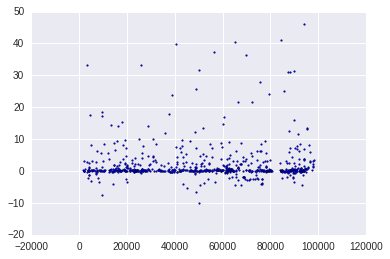

In [72]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
vals = sorted(deviances.iteritems(), key=lambda x: x[0])
positions, vals = zip(*vals)
vals = [np.nanmean(x) for x in vals]
plt.scatter(positions, vals, s=3)

In [14]:
# how many sites are always ratio of 0?
site_map = defaultdict(list)
for n, df in dev_dfs.iteritems():
    for p, d in zip(df['loc'], df['ratio']):
        site_map[p].append(d)

bad_sites = set()
for s, x in site_map.iteritems():
    if all(v==0 for v in x):
        bad_sites.add(s)

In [17]:
print len(vals), len([x for x in vals if -3 <= x <= 3])

698 550


In [16]:
len(positions)

698

In [68]:
# average ratio
ratios = defaultdict(list)
for n, df in dev_dfs.iteritems():
    for p, d in zip(df['loc'], df['ratio']):
        ratios[p].append(d)

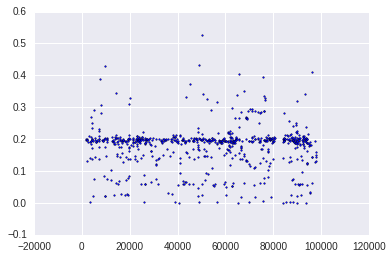

In [73]:
ratio_vals = sorted(ratios.iteritems(), key=lambda x: x[0])
positions, ratio_vals = zip(*ratio_vals)
ratio_vals = [np.nanmean(x) for x in ratio_vals]
plt.scatter(positions, ratio_vals, s=3)

In [ ]:
# need to plot this per-paralog

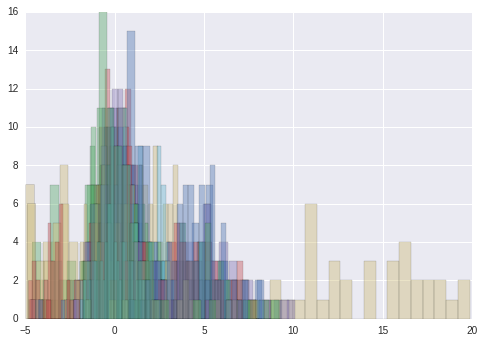

In [49]:
import random
v = deviances.values()
v = [x for x in v if len(x) > 50]
s = random.sample(v, 10)

for d in s:
    tmp = [value for value in d if not math.isnan(value)]
    tmp = [x for x in tmp if -5 < x <= 20]
    g = sns.distplot(tmp, kde=False, bins=25)

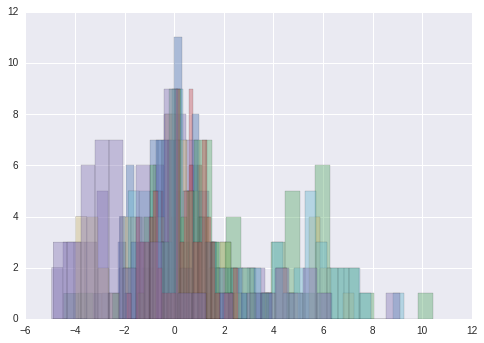

In [50]:
import random
v = deviances.values()
v = [x for x in v if len(x) > 50]
s = random.sample(v, 10)

for d in s:
    tmp = [value for value in d if not math.isnan(value)]
    tmp = [x for x in tmp if -5 < x <= 20]
    g = sns.distplot(tmp, kde=False, bins=25)

In [53]:
from collections import *

deviances_by_paralog = defaultdict(lambda: defaultdict(list))

for n, df in dev_dfs.iteritems():
    for _, s in df.iterrows():
        if s.NN > 0:
            deviances_by_paralog['NN'][s['loc']].append(s['deviance'])
        if s.NA > 0:
            deviances_by_paralog['NA'][s['loc']].append(s['deviance'])
        if s.NB > 0:
            deviances_by_paralog['NB'][s['loc']].append(s['deviance'])
        if s.NC > 0:
            deviances_by_paralog['NC'][s['loc']].append(s['deviance'])
        if s.ND > 0:
            deviances_by_paralog['ND'][s['loc']].append(s['deviance'])

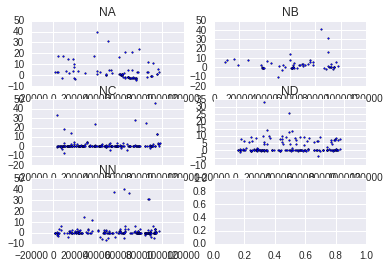

In [74]:
fig, axes = plt.subplots(ncols=2, nrows=3)
for ax, p in zip(axes.flat, deviances_by_paralog):
    vals = sorted(deviances_by_paralog[p].iteritems(), key=lambda x: x[0])
    positions, vals = zip(*vals)
    vals = [np.nanmean(x) for x in vals]
    ax.scatter(positions, vals, s=3)
    ax.set_title(p)

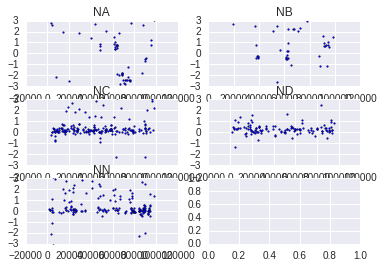

In [109]:
fig, axes = plt.subplots(ncols=2, nrows=3)
for ax, p in zip(axes.flat, deviances_by_paralog):
    vals = sorted(deviances_by_paralog[p].iteritems(), key=lambda x: x[0])
    positions, vals = zip(*vals)
    vals = [np.nanmean(x) for x in vals]
    ax.scatter(positions, vals, s=3)
    ax.set_title(p)
    ax.set_ylim(-3, 3)

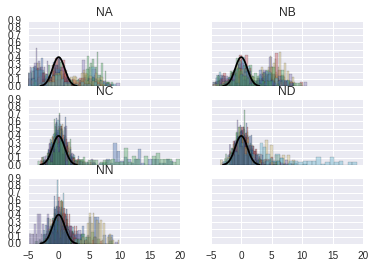

In [192]:
fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True)
import matplotlib.mlab as mlab
mu = 0
variance = 1
sigma = math.sqrt(variance)
norm_x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

for ax, p in zip(axes.flat, deviances_by_paralog):
    v = deviances_by_paralog[p].values()
    v = [x for x in v if len(x) > 50]
    s = random.sample(v, 20)
    for d in s:
        tmp = [value for value in d if not math.isnan(value)]
        tmp = [x for x in tmp if -5 < x <= 20]
        if len(tmp) > 20:
            g = sns.distplot(tmp, kde=False, bins=25, ax=ax, norm_hist=True)
            g.set_title(p)
    ax.plot(norm_x, mlab.normpdf(norm_x, mu, sigma), color='black')

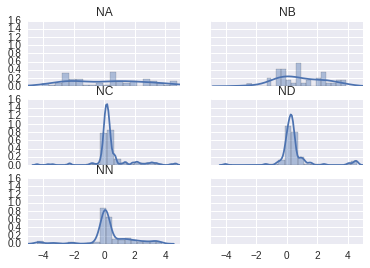

In [81]:
# distribution of average deviances for each
fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True)
for ax, p in zip(axes.flat, deviances_by_paralog):
    v = deviances_by_paralog[p].values()
    v = [np.nanmean(x) for x in v if len(x) > 25]
    v = [x for x in v if -5 < x <= 5]
    g = sns.distplot(v, bins=20, ax=ax)
    g.set_title(p)
    g.set_xlim(-5, 5)

In [179]:
# alright, here's the rules
# Each C/D/N SUN with average variance > 10 is discarded (set weight to 0)

# Otherwise, a weight is ascribed to force it to the correct value

bad_positions = {x for x, y in deviances.iteritems() if np.nanmean(y) > 3 or np.nanmean(y) < -3}

expected_alt = {}
seen_alts = defaultdict(list)
for df in dev_dfs.itervalues():
    for _, s in df.iterrows():
        if s.NA > 0 or s.NB > 0:
            continue
        e = 1.0 * (s.NA + s.NB + s.NC + s.ND + s.NN) / 10
        if e == 0:
            continue
        expected_alt[s['loc']] = e
        seen_alts[s['loc']].append(s.ratio)

In [180]:
def find_weight(expected_ratio, avg_ratio):
    return expected_ratio / avg_ratio  

weights = []
for p, e in expected_alt.iteritems():
    s = np.mean(seen_alts[p])
    weights.append([p, find_weight(e, s)])
    
weight_df = pd.DataFrame(weights, columns=['loc', 'weight'])

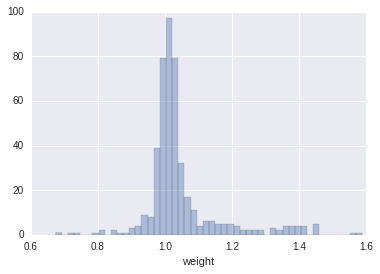

In [186]:
test = weight_df[(weight_df['loc'].isin(sun_df['loc'])) & (~weight_df['loc'].isin(bad_positions))]
sns.distplot(test.weight, kde=False, norm_hist=False)

In [225]:
# find deviance of these with the new average ratio as p
from math import *
def new_deviance(s):
    n = s.alt_count + s.ref_count
    p = s.avg_ratio
    return ((n * p) - s.alt_count) / sqrt((n * p) * (1 - p))

useful_positions = positions - bad_positions
updated_dev_dfs = {}
for n, df in dev_dfs.iteritems():
    df = df.copy()
    df = df[df['loc'].isin(useful_positions)]
    df['avg_ratio'] = [np.mean(seen_alts[p]) for p in df['loc']]
    df['adjusted_deviance'] = df.apply(new_deviance, axis=1)
    updated_dev_dfs[n] = df

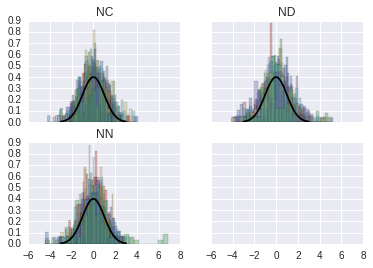

In [229]:
from collections import *

updated_deviances_by_paralog = defaultdict(lambda: defaultdict(list))

for n, df in updated_dev_dfs.iteritems():
    for _, s in df.iterrows():
        if s.NN > 0:
            updated_deviances_by_paralog['NN'][s['loc']].append(s['adjusted_deviance'])
        if s.NC > 0:
            updated_deviances_by_paralog['NC'][s['loc']].append(s['adjusted_deviance'])
        if s.ND > 0:
            updated_deviances_by_paralog['ND'][s['loc']].append(s['adjusted_deviance'])


fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
import matplotlib.mlab as mlab
mu = 0
variance = 1
sigma = math.sqrt(variance)
norm_x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

for ax, p in zip(axes.flat, updated_deviances_by_paralog):
    v = updated_deviances_by_paralog[p].values()
    v = [x for x in v if len(x) > 50]
    s = random.sample(v, 20)
    for d in s:
        tmp = [value for value in d if not math.isnan(value)]
        tmp = [x for x in tmp if -5 < x <= 20]
        if len(tmp) > 20:
            g = sns.distplot(tmp, kde=False, bins=25, ax=ax, norm_hist=True)
            g.set_title(p)
    ax.plot(norm_x, mlab.normpdf(norm_x, mu, sigma), color='black')

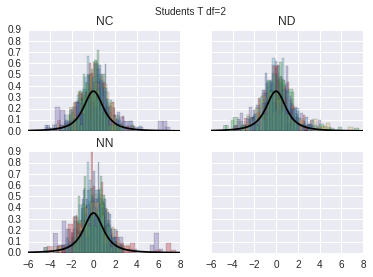

In [234]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
fig.suptitle('Students T df=2')

def t(x):
    return 1.0 / (2.0 + x ** 2) ** (3.0/2)

t_x = np.linspace(-6, 8, 1000)
t_y = [t(v) for v in t_x]

for ax, p in zip(axes.flat, updated_deviances_by_paralog):
    v = updated_deviances_by_paralog[p].values()
    v = [x for x in v if len(x) > 50]
    s = random.sample(v, 20)
    for d in s:
        tmp = [value for value in d if not math.isnan(value)]
        tmp = [x for x in tmp if -5 < x <= 20]
        if len(tmp) > 20:
            g = sns.distplot(tmp, kde=False, bins=25, ax=ax, norm_hist=True)
            g.set_title(p)
    ax.plot(t_x, t_y, color='black')

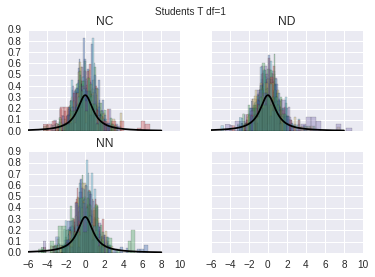

In [235]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
fig.suptitle('Students T df=1')

def t_1(x):
    return 1.0 / (math.pi * (1.0 + x ** 2))

t_x = np.linspace(-6, 8, 1000)
t_y = [t_1(v) for v in t_x]

for ax, p in zip(axes.flat, updated_deviances_by_paralog):
    v = updated_deviances_by_paralog[p].values()
    v = [x for x in v if len(x) > 50]
    s = random.sample(v, 20)
    for d in s:
        tmp = [value for value in d if not math.isnan(value)]
        tmp = [x for x in tmp if -5 < x <= 20]
        if len(tmp) > 20:
            g = sns.distplot(tmp, kde=False, bins=25, ax=ax, norm_hist=True)
            g.set_title(p)
    ax.plot(t_x, t_y, color='black')